In [1]:
import _pickle as cPickle
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
from scipy.signal import convolve2d

from tf_filters import *

from PIL import Image
%matplotlib inline

plt.rcParams['image.cmap'] = 'viridis'

In [2]:
def read_images(folder):
    fnames = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    images = [np.array(Image.open(os.path.join(folder, f))) for f in fnames]
    return np.array(images)

data = read_images('cifar/')

In [ ]:
def hog_tensor_fold(a, block_size, stride = 1):
    size_t   = a.dtype.itemsize    
    n_block  = block_size
    n_stride = stride
    n_batch, n_height, n_width, n_channel = a.shape
    
    strides = ( n_channel * n_height * n_width * size_t, 
                n_channel * n_stride * n_width * size_t, 
                n_channel * n_stride * size_t, 
                n_channel * n_width  * size_t, 
                n_channel * size_t, 
                size_t )
    
    shape   = ( n_batch, 
               (n_height - n_block) // n_stride + 1, 
                n_width // n_stride, 
                n_block, 
                n_block, 
                n_channel )
    
    result = as_strided(a, strides=strides, shape=shape)
    result = result[:, :, :(n_width - n_block)//n_stride + 1, :, :, :]
    
    #result = result.reshape((result.shape[0], 
    #                         result.shape[1]*result.shape[2],
    #                         result.shape[3],
    #                         result.shape[4],
    #                         result.shape[5]))
    
    return result

In [3]:
def hog_tensor_fold(img, block_size = 16, cell_size = 8, stride = 8):    
    size_t   = a.dtype.itemsize    
    n_block  = block_size
    n_cell   = cell_size
    n_stride = stride
    n_batch, n_height, n_width, n_channel = img.shape
    
    if (n_width - n_block) % n_stride != 0:
        raise ValueError("`img.shape[2] - block_size` must be a multiple of `stride`")
    if (n_height - n_block) % n_stride != 0:
        raise ValueError("`img.shape[1] - block_size` must be a multiple of `stride`")
    if n_block % n_cell != 0:
        raise ValueError("`block_size` must be a multiple of `cell_size`")
    
    strides = ( n_channel * n_height * n_width * size_t, # batch dimension
                n_channel * n_stride * n_width * size_t, # block Y dimension   within an image
                n_channel * n_stride * size_t,           # block X dimension   within an image
                n_channel * n_cell * n_width * size_t,   # cell Y dimension    within a block
                n_channel * n_cell * size_t,             # cell X dimension    within a block
                n_channel * n_width  * size_t,           # spatial Y dimension within a cell
                n_channel * size_t,                      # spatial X dimension within a cell
                size_t )                                 # channel dimension
    
    shape   = ( n_batch, 
               (n_height - n_block) // n_stride + 1, 
                n_width // n_stride, 
                n_block // n_cell, 
                n_block // n_cell, 
                n_cell,
                n_cell,
                n_channel )
    
    result = as_strided(img, strides=strides, shape=shape)
    result = result[:, :, :(n_width - n_block)//n_stride + 1, :, :, :]
    result = result.reshape((result.shape[0],
                             result.shape[1]*result.shape[2],
                             result.shape[3]*result.shape[4],
                             result.shape[5],
                             result.shape[6],
                             result.shape[7]))
    
    return result

In [93]:
def tf_deriv(batch, ksize=3, padding='SAME'):
    try:
        n_ch = batch.shape[3]
    except:
        n_ch = int(batch.get_shape()[3])
    gx = tf_kernel_prep_3d(np.array([[ 0, 0, 0],
                                     [-1, 0, 1],
                                     [ 0, 0, 0]]), n_ch)    
    gy = tf_kernel_prep_3d(np.array([[ 0,-1, 0],
                                     [ 0, 0, 0],
                                     [ 0, 1, 0]]), n_ch)   
    kernel = tf.constant(np.stack([gx, gy], axis=-1), dtype = np.float32)
    return tf.nn.depthwise_conv2d(batch, kernel, [1, 1, 1, 1], padding=padding)

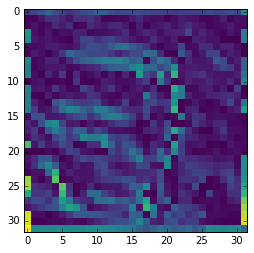

In [220]:
# tensorflow code

tf.reset_default_graph()

grayscale = False
oriented = False
n_bins = 9
cell_size = 8
block_size = 16
stride = 8

k = 1
X = data[:10]

img_idx, row_idx, col_idx, _ = np.indices(X.shape)
img_idx = tf.constant(img_idx, dtype=tf.int32)
row_idx = tf.constant(row_idx, dtype=tf.int32)
col_idx = tf.constant(col_idx, dtype=tf.int32)

img    = tf.constant(X, dtype=tf.float32)
kernel = tf.constant([[-1,0,1]], dtype=tf.float32)

if grayscale:
    gray = tf.image.rgb_to_grayscale(img)
    grad = tf_deriv(gray)
else:
    grad = tf_deriv(img)
    
gx = grad[:,:,:,0::2]
gy = grad[:,:,:,1::2]   
gmag = tf.sqrt(tf.square(gx) + tf.square(gy))

max_idx = tf.argmax(gmag, 3)
max_idx = tf.to_int32(max_idx)
max_idx = tf.pack([max_idx, max_idx, max_idx])
max_idx = tf.transpose(max_idx, [1,2,3,0])

idx = tf.pack([img_idx, row_idx, col_idx, max_idx])
idx = tf.transpose(idx, [1,2,3,4,0])

gmax = tf.gather_nd(gmag, idx)[:,:,:,0] 
gx   = tf.gather_nd(gx, idx)[:,:,:,0] 
gy   = tf.gather_nd(gy, idx)[:,:,:,0]

if oriented:
    raise Exception("`oriented` gradient not supported yet")
else:
    gdir = tf.atan(gy / gx)
    neg_mask = tf.where(gdir < 0)
    neg_corr = tf.sparse_to_dense(neg_mask, gdir.get_shape(), np.pi)
    gdir = gdir + neg_corr
    #gbin = tf.to_int32(tf.floor(gdir / np.pi * n_bins * 0.99999))
    
    gw = gmax*gdir


init_op = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init_op)
    g = gw.eval()
    i = idx.eval()
    plt.imshow(g[6,:,:], interpolation='nearest')

In [173]:
a = tf.constant(np.random.randint(-10, 10, (10,8,8)), dtype=tf.int32)
mask = tf.where(a < 0)
mask = tf.sparse_to_dense(mask, a.get_shape(), 1000)
b = a + mask

init_op = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init_op)
    #print(b.eval())

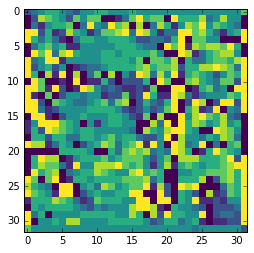

In [213]:
# numpy code

grayscale = False
oriented = False
n_bins = 9

k = 6
X = data[:10]
kernel = np.array([[1,0,-1]])

if grayscale:
    img = X[k].mean(axis=2)    
    gx = convolve2d(img, kernel,   mode = 'same')
    gy = convolve2d(img, kernel.T, mode = 'same')   
    g_mag = np.sqrt(gx**2 + gy**2)
    
else:
    img = X[k]
    gx = np.stack([convolve2d(img[:,:,0], kernel,   mode = 'same'),
                   convolve2d(img[:,:,1], kernel,   mode = 'same'),
                   convolve2d(img[:,:,2], kernel,   mode = 'same')], axis=-1)
    
    gy = np.stack([convolve2d(img[:,:,0], kernel.T, mode = 'same'),
                   convolve2d(img[:,:,1], kernel.T, mode = 'same'),
                   convolve2d(img[:,:,2], kernel.T, mode = 'same')], axis=-1)
    
    g_mag = np.sqrt(gx**2 + gy**2)
    ch_idx = np.argmax(g_mag, axis = 2)
    row_idx, col_idx = np.indices((g_mag.shape[0], g_mag.shape[1]))
    
    gx = gx[row_idx, col_idx, ch_idx]
    gy = gy[row_idx, col_idx, ch_idx]
    g_mag = g_mag[row_idx, col_idx, ch_idx]

g_dir = np.arctan2(gy, gx)
if oriented:
    g_dir += np.pi
    g_bin = np.floor(g_dir / np.pi * n_bins * 0.4999999)
else:
    g_dir[g_dir < 0] += np.pi
    g_bin = np.floor(g_dir / np.pi * n_bins * 0.99999)
    
g_bin = g_bin.reshape(g_bin.shape[0], g_bin.shape[1], -1)

plt.imshow(g_bin[:,:,0], interpolation='nearest')

In [ ]:
#a = X[0].copy() #np.arange(64).reshape((8,8))
Z = hog_tensor_fold(X.copy(), 16, 8, 16)
#Z = Z.reshape(10,9,16,16,3)

k = 0

W = np.vstack([
        np.hstack([
            np.vstack([
                np.hstack([Z[k,0,0],Z[k,0,1]]), 
                np.hstack([Z[k,0,2],Z[k,0,3]])
            ]),
            np.vstack([
                np.hstack([Z[k,1,0],Z[k,1,1]]), 
                np.hstack([Z[k,1,2],Z[k,1,3]])
            ])
        ]),
        np.hstack([
            np.vstack([
                np.hstack([Z[k,2,0],Z[k,2,1]]),
                np.hstack([Z[k,2,2],Z[k,2,3]])
            ]),
            np.vstack([
                np.hstack([Z[k,3,0],Z[k,3,1]]), 
                np.hstack([Z[k,3,2],Z[k,3,3]])
            ])
        ])
    ])

plt.imshow(W, interpolation='nearest')
#Z.shape

In [ ]:
Z.shape

In [ ]:
X[0,:,:,0]